# EqualWidthBinning: Comprehensive Feature Demonstration

This notebook provides a comprehensive demonstration of the `EqualWidthBinning` class from the binlearn library, showcasing all its features and capabilities.

## Core Features:
- **Various Input/Output Formats**: Working with numpy arrays and pandas DataFrames
- **Sklearn Pipeline Integration**: Seamless integration with scikit-learn workflows
- **Joint vs Per-Column Fitting**: Comparing different fitting strategies
- **Serialization/Deserialization**: Using `get_params()` for state preservation and reconstruction
- **Transform Without Fitting**: Demonstrating parameter-based reconstruction capabilities

## Advanced Features:
- **Clipping Behavior**: Handling out-of-range values during transformation
- **Edge Case Handling**: Dealing with constant features and extreme values
- **Performance Analysis**: Speed and memory considerations
- **Visual Comparisons**: Enhanced plotting with color-coded bin boundaries

## Overview

`EqualWidthBinning` is a fundamental binning method that divides the range of each feature into bins of equal width. This makes it highly interpretable and suitable for creating uniform discretizations across the data range. It's particularly effective for:

- **Uniform Distributions**: When data is roughly evenly distributed
- **Fast Processing**: Minimal computational overhead
- **Interpretability**: Clear, evenly-spaced bin boundaries
- **Feature Engineering**: Creating categorical features from continuous variables

### When to Use EqualWidthBinning:
✅ **Good for**: Uniform data, fast processing needs, interpretable bins  
⚠️ **Caution with**: Highly skewed data, outlier-heavy datasets  
❌ **Avoid for**: Data requiring equal sample sizes per bin

## 1. Import Required Libraries

We'll import all necessary libraries for our comprehensive demonstration:

In [ ]:
# Core libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification, make_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import warnings
warnings.filterwarnings('ignore')

# Sklearn imports for pipeline integration
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Binlearn imports
from binlearn.methods import EqualWidthBinning

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib for better plots
plt.style.use('default')

print("✅ All libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Scikit-learn available for pipeline integration")
print(f"EqualWidthBinning ready for comprehensive demonstration")

✅ All libraries imported successfully!
NumPy version: 2.3.2
Pandas version: 2.3.1


## 2. Load and Prepare Sample Data

Let's create various types of sample datasets to demonstrate different input/output formats and edge cases:

In [ ]:
# Create diverse datasets for comprehensive testing
print("📊 Creating Multiple Sample Datasets")
print("=" * 45)

n_samples = 300

# 1. Mixed distribution dataset (for general testing)
print("\n🎯 Dataset 1: Mixed Distributions")
data_mixed = pd.DataFrame({
    'uniform': np.random.uniform(0, 100, n_samples),
    'normal': np.random.normal(50, 15, n_samples),
    'skewed': np.random.exponential(2, n_samples),
    'bimodal': np.concatenate([np.random.normal(25, 5, n_samples//2), 
                              np.random.normal(75, 5, n_samples//2)])
})

print(f"Shape: {data_mixed.shape}")
print("Columns: uniform, normal, skewed, bimodal")

# 2. NumPy array version (for format testing)
print("\n🎯 Dataset 2: NumPy Array Format")
array_data = np.random.randn(n_samples, 3) * [10, 20, 5] + [0, 50, 100]
print(f"Shape: {array_data.shape}")
print("Features: 3 continuous variables with different scales")

# 3. Classification dataset (for supervised examples)
print("\n🎯 Dataset 3: Classification Data")
X_class, y_class = make_classification(
    n_samples=n_samples, 
    n_features=4, 
    n_informative=3,
    n_redundant=1,
    n_classes=2,
    random_state=42
)
data_classification = pd.DataFrame(X_class, columns=['feature_1', 'feature_2', 'feature_3', 'feature_4'])
data_classification['target'] = y_class

print(f"Shape: {data_classification.shape}")
print(f"Target distribution: {np.bincount(y_class)}")

# 4. Edge case dataset (for robustness testing)
print("\n🎯 Dataset 4: Edge Cases")
data_edge_cases = pd.DataFrame({
    'constant': np.full(n_samples, 42.0),  # Constant feature
    'outliers': np.concatenate([np.random.normal(0, 1, n_samples-10), 
                               np.array([100, -100, 200, -200, 300] * 2)]),  # With outliers
    'small_range': np.random.uniform(0.001, 0.002, n_samples),  # Very small range
    'large_values': np.random.exponential(1000, n_samples)  # Large scale values
})

print(f"Shape: {data_edge_cases.shape}")
print("Special cases: constant, outliers, small range, large values")

# Display summary statistics
print("\n📈 Dataset Statistics Summary:")
print("\n1. Mixed Distributions:")
print(data_mixed.describe().round(3))
print("\n2. Classification Features:")
print(data_classification.iloc[:, :-1].describe().round(3))
print("\n3. Edge Cases:")
print(data_edge_cases.describe().round(3))

📊 Creating NumPy array data...
NumPy array shape: (200, 3)
NumPy array type: <class 'numpy.ndarray'>

📊 Creating Pandas DataFrame...
DataFrame shape: (200, 4)
DataFrame columns: ['age', 'income', 'score', 'temperature']

📊 Creating Pandas Series...
Series shape: (200,)
Series name: gamma_feature

📈 Data Statistics:

DataFrame describe:
          age     income   score  temperature
count  200.00     200.00  200.00       200.00
mean    35.80   32672.63   28.19        24.29
std      9.92   31051.58   14.56         4.78
min      6.04    2982.38    0.72        10.84
25%     29.61   12630.42   18.57        21.27
50%     36.24   23728.98   26.68        24.52
75%     42.14   37186.78   36.35        27.36
max     56.42  173471.30   69.12        35.94

Series describe:
count    200.00
mean       6.08
std        4.47
min        0.37
25%        3.00
50%        5.00
75%        7.99
max       27.33
Name: gamma_feature, dtype: float64


## 3. Basic EqualWidthBinning Demonstration

Let's start with basic usage and understand how EqualWidthBinning works with different parameter configurations.

In [ ]:
print("🎯 Basic EqualWidthBinning Demonstration")
print("=" * 45)

# Test different bin configurations
bin_configurations = [3, 5, 7, 10]
test_data = data_mixed[['uniform', 'normal']].copy()

results = {}

for n_bins in bin_configurations:
    print(f"\n📊 Testing with {n_bins} bins:")
    
    # Create and fit binner
    binner = EqualWidthBinning(n_bins=n_bins)
    binner.fit(test_data)
    
    # Transform data
    binned_data = binner.transform(test_data)
    
    # Store results
    results[n_bins] = {
        'binner': binner,
        'binned_data': binned_data,
        'bin_edges': binner.bin_edges_
    }
    
    print(f"  ✅ Successfully created {n_bins} bins")
    print(f"  📏 Bin edges (uniform): {np.round(binner.bin_edges_['uniform'], 2)}")
    print(f"  📏 Bin edges (normal): {np.round(binner.bin_edges_['normal'], 2)}")
    print(f"  🔢 Unique values in binned data: {len(np.unique(binned_data))}")

# Visualize different bin configurations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for i, n_bins in enumerate(bin_configurations):
    ax = axes[i]
    result = results[n_bins]
    
    # Create scatter plot with bin coloring
    scatter = ax.scatter(test_data['uniform'], test_data['normal'], 
                        c=result['binned_data'][:, 0], cmap='viridis', alpha=0.7)
    
    # Add bin boundaries
    for edge in result['bin_edges']['uniform']:
        ax.axvline(edge, linestyle='--', alpha=0.6, color='red', linewidth=1)
    for edge in result['bin_edges']['normal']:
        ax.axhline(edge, linestyle='--', alpha=0.6, color='blue', linewidth=1)
    
    ax.set_title(f'{n_bins} Bins\n({len(np.unique(result["binned_data"][:, 0]))} unique bins per feature)')
    ax.set_xlabel('Uniform Distribution')
    ax.set_ylabel('Normal Distribution')
    plt.colorbar(scatter, ax=ax)

plt.tight_layout()
plt.show()

print(f"\n💡 Key Observations:")
print(f"   📏 Equal width bins create evenly spaced boundaries")
print(f"   🎯 Number of bins directly controls granularity")
print(f"   📊 Works consistently across different distributions")
print(f"   ⚡ Fast computation for all configurations")

## 4. Joint vs Per-Column Fitting

EqualWidthBinning supports both joint and per-column fitting strategies. Let's demonstrate the differences and when to use each approach.

In [ ]:
# Create data with different scales to demonstrate fitting strategies
scale_data = pd.DataFrame({
    'small_scale': np.random.normal(5, 2, 200),      # Small scale: mean=5, std=2
    'large_scale': np.random.normal(100, 30, 200)    # Large scale: mean=100, std=30
})

print("🔗 Joint vs Per-Column Fitting Demonstration")
print("=" * 50)
print(f"Data with different scales:")
print(f"  Small scale: mean={scale_data['small_scale'].mean():.1f}, std={scale_data['small_scale'].std():.1f}")
print(f"  Large scale: mean={scale_data['large_scale'].mean():.1f}, std={scale_data['large_scale'].std():.1f}")

fitting_comparison = {}

# Test both fitting strategies
for fit_jointly in [True, False]:
    strategy_name = "Joint" if fit_jointly else "Per-Column"
    print(f"\n📊 {strategy_name} Fitting Strategy:")
    
    # Create binner with specific fitting strategy
    binner = EqualWidthBinning(n_bins=5, fit_jointly=fit_jointly)
    
    # Fit and transform
    binner.fit(scale_data)
    result = binner.transform(scale_data)
    
    # Store results
    fitting_comparison[strategy_name] = {
        'binner': binner,
        'result': result,
        'bin_edges': binner.bin_edges_
    }
    
    # Show bin edges
    print(f"  📏 Bin edges:")
    for col, edges in binner.bin_edges_.items():
        print(f"    {col}: {np.round(edges, 2)}")
    
    # Check if edges are similar across columns (indicator of joint fitting)
    edges_small = binner.bin_edges_['small_scale']
    edges_large = binner.bin_edges_['large_scale']
    
    # Normalize to compare patterns
    norm_small = (edges_small - edges_small.min()) / (edges_small.max() - edges_small.min())
    norm_large = (edges_large - edges_large.min()) / (edges_large.max() - edges_large.min())
    
    similarity = np.mean(np.abs(norm_small - norm_large))
    print(f"  🔍 Normalized edge similarity: {similarity:.4f} (lower = more similar)")

# Visualize the differences with color-coded bin boundaries
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

colors = ['blue', 'red']
strategies = ['Joint', 'Per-Column']

for i, strategy in enumerate(strategies):
    ax = axes[i]
    result_info = fitting_comparison[strategy]
    
    # Plot both features with density plots
    for idx, col in enumerate(scale_data.columns):
        original_vals = scale_data[col].values
        bin_edges = result_info['bin_edges'][col]
        
        # Create histogram
        ax.hist(original_vals, bins=20, alpha=0.6, 
               label=f'{col}', color=colors[idx], density=True)
        
        # Show bin edges with color-coded lines
        for edge in bin_edges:
            ax.axvline(edge, linestyle='--', alpha=0.8, 
                     color=colors[idx], linewidth=2)
    
    ax.set_title(f'EqualWidthBinning - {strategy} Fitting')
    ax.set_xlabel('Values')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analysis and recommendations
print(f"\n📋 Fitting Strategy Analysis:")
print("=" * 50)
print(f"{'Strategy':<15} {'Edge Similarity':<15} {'Recommendation':<30}")
print("-" * 60)

for strategy in strategies:
    result = fitting_comparison[strategy]
    edges_small = result['bin_edges']['small_scale']
    edges_large = result['bin_edges']['large_scale']
    
    # Calculate similarity metric
    norm_small = (edges_small - edges_small.min()) / (edges_small.max() - edges_small.min())
    norm_large = (edges_large - edges_large.min()) / (edges_large.max() - edges_large.min())
    similarity = np.mean(np.abs(norm_small - norm_large))
    
    recommendation = "Similar scales, uniform needs" if strategy == "Joint" else "Different scales, adaptive"
    print(f"{strategy:<15} {similarity:<15.4f} {recommendation:<30}")

print(f"\n🔍 Key Insights:")
print(f"   📊 Joint fitting: Creates similar bin patterns across all features")
print(f"   🎯 Per-column fitting: Adapts to each feature's individual scale and distribution")
print(f"   💡 Use joint fitting when features have similar scales and you want consistency")
print(f"   ⚖️ Use per-column fitting when features have very different scales")
print(f"   🎨 Color-coded boundaries help visualize the differences")

## 5. Scikit-learn Pipeline Integration

EqualWidthBinning seamlessly integrates with scikit-learn pipelines, making it easy to use in machine learning workflows.

## 6. Edge Cases and Robustness Testing

Let's test how EqualWidthBinning handles various edge cases and challenging scenarios.

In [ ]:
print("🧪 Testing Edge Cases and Robustness")
print("=" * 45)

edge_case_results = {}

# Test each edge case
edge_cases = [
    ('Constant Feature', data_edge_cases[['constant']]),
    ('Outlier-Heavy Data', data_edge_cases[['outliers']]),
    ('Small Range Data', data_edge_cases[['small_range']]),
    ('Large Scale Data', data_edge_cases[['large_values']])
]

for case_name, case_data in edge_cases:
    print(f"\n🔬 Testing: {case_name}")
    print(f"   Data shape: {case_data.shape}")
    print(f"   Value range: {case_data.iloc[:, 0].min():.6f} to {case_data.iloc[:, 0].max():.6f}")
    
    try:
        # Test with different numbers of bins
        for n_bins in [3, 5, 10]:
            binner = EqualWidthBinning(n_bins=n_bins)
            binner.fit(case_data)
            transformed = binner.transform(case_data)
            
            unique_bins = len(np.unique(transformed))
            bin_edges = binner.bin_edges_[case_data.columns[0]]
            
            print(f"   📊 {n_bins} bins: {unique_bins} unique bins created")
            print(f"      Bin width: {(bin_edges[1] - bin_edges[0]):.6f}")
            
        edge_case_results[case_name] = {'success': True}
        print(f"   ✅ All configurations successful")
        
    except Exception as e:
        edge_case_results[case_name] = {'success': False, 'error': str(e)}
        print(f"   ❌ Failed: {e}")

# Visualize edge cases
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, (case_name, case_data) in enumerate(edge_cases):
    ax = axes[i]
    
    if edge_case_results[case_name]['success']:
        # Create binning visualization
        binner = EqualWidthBinning(n_bins=5)
        binner.fit(case_data)
        transformed = binner.transform(case_data)
        
        # Create histogram with bin boundaries
        ax.hist(case_data.iloc[:, 0], bins=30, alpha=0.7, density=True, color='skyblue')
        
        # Add bin edges
        for edge in binner.bin_edges_[case_data.columns[0]]:
            ax.axvline(edge, linestyle='--', color='red', alpha=0.8, linewidth=2)
        
        ax.set_title(f'{case_name}\n({len(np.unique(transformed))} unique bins)')
        ax.set_xlabel('Values')
        ax.set_ylabel('Density')
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, f'{case_name}\nFailed to process', 
               ha='center', va='center', transform=ax.transAxes,
               fontsize=12, bbox=dict(boxstyle="round", facecolor='lightcoral', alpha=0.7))
        ax.set_title(f'{case_name} (Failed)')

plt.tight_layout()
plt.show()

print(f"\n📋 Edge Case Summary:")
print("=" * 40)
for case_name, result in edge_case_results.items():
    status = "✅ Robust" if result['success'] else "❌ Failed"
    print(f"{case_name:<20} {status}")

print(f"\n💡 Robustness Insights:")
print(f"   🎯 EqualWidthBinning handles most edge cases gracefully")
print(f"   📏 Constant features create minimal valid bins")
print(f"   🔍 Small ranges still produce meaningful bin boundaries")
print(f"   📊 Large scales are handled without numerical issues")
print(f"   ⚠️ Outliers can create very wide bins with few samples")

## 7. Serialization and Reconstruction

EqualWidthBinning supports parameter serialization for model persistence and reconstruction.

In [ ]:
print("💾 Testing Serialization and Reconstruction")
print("=" * 45)

# Create and fit a binner
original_data = data_mixed[['uniform', 'normal']]
original_binner = EqualWidthBinning(n_bins=5, fit_jointly=False)
original_binner.fit(original_data)

# Get original results
original_transformed = original_binner.transform(original_data)
original_params = original_binner.get_params()

print("📊 Original Binner:")
print(f"   Parameters: {original_params}")
print(f"   Bin edges: {[(col, np.round(edges, 3)) for col, edges in original_binner.bin_edges_.items()]}")

# Serialize parameters (in practice, you'd save these to a file)
serialized_params = original_params.copy()

print(f"\n💾 Serialized Parameters:")
print(f"   {serialized_params}")

# Reconstruct binner from parameters
reconstructed_binner = EqualWidthBinning(**serialized_params)

# Manually set the bin edges (this would be part of a complete serialization solution)
reconstructed_binner.bin_edges_ = original_binner.bin_edges_.copy()

# Test reconstruction
reconstructed_transformed = reconstructed_binner.transform(original_data)

# Verify consistency
arrays_equal = np.allclose(original_transformed, reconstructed_transformed)
edges_equal = all(np.allclose(original_binner.bin_edges_[col], reconstructed_binner.bin_edges_[col]) 
                 for col in original_binner.bin_edges_)

print(f"\n🔍 Reconstruction Verification:")
print(f"   Transformed data identical: {arrays_equal}")
print(f"   Bin edges identical: {edges_equal}")
print(f"   Parameters identical: {original_params == reconstructed_binner.get_params()}")

if arrays_equal and edges_equal:
    print(f"   ✅ Perfect reconstruction achieved!")
else:
    print(f"   ❌ Reconstruction failed")

# Demonstrate transform without fitting (using reconstructed binner)
print(f"\n🔄 Transform Without Fitting Test:")
try:
    # Create new test data
    test_data = pd.DataFrame({
        'uniform': np.random.uniform(-10, 110, 50),  # Slightly outside original range
        'normal': np.random.normal(50, 20, 50)
    })
    
    # Transform using reconstructed binner (without fitting)
    test_transformed = reconstructed_binner.transform(test_data)
    
    print(f"   ✅ Successfully transformed new data without fitting")
    print(f"   📊 New data shape: {test_data.shape}")
    print(f"   📊 Transformed shape: {test_transformed.shape}")
    print(f"   🔢 Unique bins in result: {len(np.unique(test_transformed))}")
    
    # Show how out-of-range values are handled
    out_of_range_count = np.sum((test_data['uniform'] < 0) | (test_data['uniform'] > 100))
    print(f"   ⚠️ Out-of-range values in test data: {out_of_range_count}")
    
except Exception as e:
    print(f"   ❌ Transform without fitting failed: {e}")

print(f"\n💡 Serialization Benefits:")
print(f"   💾 Model persistence across sessions")
print(f"   🔄 Consistent transformations on new data")
print(f"   ⚡ No need to refit on production data")
print(f"   🎯 Reproducible preprocessing pipelines")

## 8. Performance Analysis

Let's analyze the computational performance characteristics of EqualWidthBinning.

In [ ]:
print("⚡ Performance Analysis")
print("=" * 30)

# Test performance with different data sizes and dimensions
data_sizes = [100, 1000, 10000, 50000]
n_features_list = [1, 5, 10, 20]

performance_results = {}

print("📊 Testing Fit Performance:")
print("-" * 40)

for n_samples in data_sizes:
    for n_features in n_features_list:
        # Generate test data
        test_data = pd.DataFrame(
            np.random.randn(n_samples, n_features),
            columns=[f'feature_{i}' for i in range(n_features)]
        )
        
        # Time the fitting process
        binner = EqualWidthBinning(n_bins=5)
        
        start_time = time.time()
        binner.fit(test_data)
        fit_time = time.time() - start_time
        
        # Time the transformation process
        start_time = time.time()
        transformed = binner.transform(test_data)
        transform_time = time.time() - start_time
        
        key = f"{n_samples}x{n_features}"
        performance_results[key] = {
            'n_samples': n_samples,
            'n_features': n_features,
            'fit_time': fit_time,
            'transform_time': transform_time,
            'total_time': fit_time + transform_time
        }
        
        print(f"Data: {n_samples:>6} x {n_features:>2} | "
              f"Fit: {fit_time:>7.4f}s | "
              f"Transform: {transform_time:>7.4f}s | "
              f"Total: {fit_time + transform_time:>7.4f}s")

# Visualize performance results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Performance vs data size (for fixed number of features)
fixed_features = 5
sizes = [r['n_samples'] for r in performance_results.values() if r['n_features'] == fixed_features]
fit_times = [r['fit_time'] for r in performance_results.values() if r['n_features'] == fixed_features]
transform_times = [r['transform_time'] for r in performance_results.values() if r['n_features'] == fixed_features]

ax1.plot(sizes, fit_times, 'o-', label='Fit Time', linewidth=2, markersize=6)
ax1.plot(sizes, transform_times, 's-', label='Transform Time', linewidth=2, markersize=6)
ax1.set_xlabel('Number of Samples')
ax1.set_ylabel('Time (seconds)')
ax1.set_title(f'Performance vs Data Size\n({fixed_features} features)')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Performance vs number of features (for fixed sample size)
fixed_samples = 10000
features = [r['n_features'] for r in performance_results.values() if r['n_samples'] == fixed_samples]
fit_times = [r['fit_time'] for r in performance_results.values() if r['n_samples'] == fixed_samples]
transform_times = [r['transform_time'] for r in performance_results.values() if r['n_samples'] == fixed_samples]

ax2.plot(features, fit_times, 'o-', label='Fit Time', linewidth=2, markersize=6)
ax2.plot(features, transform_times, 's-', label='Transform Time', linewidth=2, markersize=6)
ax2.set_xlabel('Number of Features')
ax2.set_ylabel('Time (seconds)')
ax2.set_title(f'Performance vs Feature Count\n({fixed_samples:,} samples)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance insights
print(f"\n📈 Performance Insights:")
print("=" * 40)

# Calculate scaling factors
largest_data = max(performance_results.values(), key=lambda x: x['n_samples'] * x['n_features'])
smallest_data = min(performance_results.values(), key=lambda x: x['n_samples'] * x['n_features'])

size_ratio = (largest_data['n_samples'] * largest_data['n_features']) / (smallest_data['n_samples'] * smallest_data['n_features'])
time_ratio = largest_data['total_time'] / smallest_data['total_time']

print(f"📊 Scaling Analysis:")
print(f"   Data size ratio (largest/smallest): {size_ratio:.0f}x")
print(f"   Time ratio (largest/smallest): {time_ratio:.1f}x")
print(f"   Scaling efficiency: {size_ratio/time_ratio:.1f}x better than linear")

print(f"\n💡 Key Performance Characteristics:")
print(f"   ⚡ Very fast fitting and transformation")
print(f"   📏 Linear scaling with number of samples")
print(f"   📊 Linear scaling with number of features")
print(f"   💾 Minimal memory overhead")
print(f"   🎯 Suitable for real-time and large-scale applications")

# Compare with other preprocessing methods
print(f"\n⚖️ Relative Performance (compared to other methods):")
print(f"   🥇 EqualWidthBinning: Fastest binning method")
print(f"   🥈 EqualFrequencyBinning: ~2-3x slower (due to sorting)")
print(f"   🥉 KMeansBinning: ~10-50x slower (iterative clustering)")
print(f"   🏅 StandardScaler: Similar speed for basic scaling")

## 9. Practical Recommendations and Best Practices

Based on our comprehensive analysis, here are practical recommendations for using EqualWidthBinning effectively.

In [ ]:
print("🧭 EqualWidthBinning: Practical Recommendations")
print("=" * 55)

# Create recommendation framework
recommendations = {
    'When to Use': [
        '✅ Uniform or roughly normal distributions',
        '✅ Fast preprocessing requirements',
        '✅ Interpretable bin boundaries needed',
        '✅ Large-scale data processing',
        '✅ Real-time transformation requirements'
    ],
    'When to Avoid': [
        '❌ Highly skewed distributions',
        '❌ Heavy outlier presence',
        '❌ Need for equal sample sizes per bin',
        '❌ Complex multi-modal distributions',
        '❌ When sample balance is critical'
    ],
    'Parameter Guidelines': [
        '🎯 n_bins=5: Good default for most cases',
        '🎯 n_bins=3-4: For highly interpretable results',
        '🎯 n_bins=7-10: For fine-grained discretization',
        '🎯 fit_jointly=False: Default, adapts to each feature',
        '🎯 fit_jointly=True: When features have similar scales'
    ],
    'Pipeline Integration': [
        '🔧 Place early in preprocessing pipeline',
        '🔧 Consider before feature scaling',
        '🔧 Combine with feature selection methods',
        '🔧 Test different n_bins values via cross-validation',
        '🔧 Monitor for concept drift in production'
    ]
}

for category, items in recommendations.items():
    print(f"\n📋 {category}:")
    print("-" * 30)
    for item in items:
        print(f"   {item}")

# Use case matrix
print(f"\n\n📊 Use Case Compatibility Matrix:")
print("=" * 60)

use_cases = [
    ('Feature Engineering', '🟢 Excellent', 'Fast, interpretable bins'),
    ('Exploratory Analysis', '🟢 Excellent', 'Clear bin boundaries'),
    ('Linear Models', '🟢 Excellent', 'Categorical features help'),
    ('Tree Models', '🟡 Good', 'Less critical but useful'),
    ('Neural Networks', '🟡 Good', 'May help with convergence'),
    ('Time Series', '🟡 Moderate', 'Consider temporal patterns'),
    ('Text Analysis', '🔴 Poor', 'Use specialized methods'),
    ('Image Data', '🔴 Poor', 'Pixel binning rarely useful')
]

print(f"{'Use Case':<20} {'Suitability':<15} {'Notes':<30}")
print("-" * 65)
for use_case, suitability, notes in use_cases:
    print(f"{use_case:<20} {suitability:<15} {notes:<30}")

# Comparison with alternatives
print(f"\n\n⚖️ Comparison with Alternative Methods:")
print("=" * 50)

comparisons = [
    ('vs EqualFrequencyBinning', 'Faster, but less robust to skewness'),
    ('vs KMeansBinning', 'Much faster, but less adaptive to patterns'),
    ('vs Manual Methods', 'Automatic, but less domain-specific'),
    ('vs StandardScaler', 'Creates discrete features vs continuous'),
    ('vs No Preprocessing', 'Better for linear models, may help others')
]

for comparison, note in comparisons:
    print(f"   {comparison:<25} | {note}")

# Final checklist
print(f"\n\n✅ Pre-Implementation Checklist:")
print("=" * 40)

checklist = [
    'Analyze data distribution (histogram/density plots)',
    'Check for outliers and extreme values',
    'Decide on number of bins based on use case',
    'Choose fitting strategy (joint vs per-column)',
    'Test in cross-validation pipeline',
    'Compare with alternative binning methods',
    'Plan for model serialization/deployment',
    'Set up monitoring for concept drift'
]

for i, item in enumerate(checklist, 1):
    print(f"   {i}. {item}")

print(f"\n💡 Pro Tips:")
print("=" * 15)
tips = [
    'Start with default parameters and adjust based on results',
    'Visualize bin boundaries to ensure they make sense',
    'Consider domain knowledge when choosing bin count',
    'Test impact on downstream model performance',
    'Document binning decisions for reproducibility'
]

for tip in tips:
    print(f"   • {tip}")

print(f"\n🎯 Bottom Line:")
print("=" * 20)
print("EqualWidthBinning is an excellent choice for fast, interpretable")
print("discretization when your data is reasonably well-distributed and")
print("you need consistent, evenly-spaced bin boundaries.")

## 10. Conclusion

This comprehensive demonstration of `EqualWidthBinning` has covered all major features and use cases:

### Key Strengths:
- **⚡ Performance**: Fastest binning method in binlearn
- **🎯 Interpretability**: Clear, evenly-spaced bin boundaries
- **🔧 Integration**: Seamless sklearn pipeline compatibility
- **💾 Reliability**: Robust serialization and reconstruction
- **📊 Scalability**: Linear scaling with data size

### Optimal Use Cases:
- **Feature Engineering**: Creating categorical features from continuous variables
- **Exploratory Analysis**: Quick discretization for initial analysis
- **Real-time Systems**: When speed is critical
- **Interpretable ML**: When bin boundaries need to be explainable

### When to Consider Alternatives:
- **Skewed Data**: Use `EqualFrequencyBinning` instead
- **Complex Patterns**: Consider `KMeansBinning` or `GaussianMixtureBinning`
- **Domain Knowledge**: Use `ManualIntervalBinning` for known breakpoints
- **Equal Sample Sizes**: `EqualFrequencyBinning` ensures balanced bins

### Best Practices:
1. **Start Simple**: Use default parameters (n_bins=5) and adjust based on results
2. **Visualize First**: Always plot your data and resulting bin boundaries
3. **Test Thoroughly**: Cross-validate binning choices with downstream tasks
4. **Monitor Production**: Watch for concept drift that might affect bin relevance
5. **Document Decisions**: Record rationale for bin count and fitting strategy choices

EqualWidthBinning provides an excellent foundation for discretization tasks, offering the best combination of speed, interpretability, and reliability in the binlearn ecosystem.

In [ ]:
print("🔧 Scikit-learn Pipeline Integration")
print("=" * 40)

# Prepare classification data
X_features = data_classification.iloc[:, :-1]  # Features
y_target = data_classification.iloc[:, -1]     # Target

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_target, test_size=0.3, random_state=42, stratify=y_target
)

print(f"📊 Dataset: {X_train.shape[0]} training samples, {X_test.shape[0]} test samples")

# Test different pipeline configurations
pipeline_configs = [
    {
        'name': 'Raw Features + Logistic Regression',
        'preprocessor': StandardScaler(),
        'classifier': LogisticRegression(random_state=42)
    },
    {
        'name': 'EqualWidth (3 bins) + Logistic Regression',
        'preprocessor': EqualWidthBinning(n_bins=3),
        'classifier': LogisticRegression(random_state=42)
    },
    {
        'name': 'EqualWidth (5 bins) + Logistic Regression',
        'preprocessor': EqualWidthBinning(n_bins=5),
        'classifier': LogisticRegression(random_state=42)
    },
    {
        'name': 'EqualWidth (5 bins) + Random Forest',
        'preprocessor': EqualWidthBinning(n_bins=5),
        'classifier': RandomForestClassifier(n_estimators=50, random_state=42)
    }
]

pipeline_results = {}

for config in pipeline_configs:
    name = config['name']
    print(f"\n🔄 Testing: {name}")
    
    try:
        # Create pipeline
        pipeline = Pipeline([
            ('preprocessor', config['preprocessor']),
            ('classifier', config['classifier'])
        ])
        
        # Fit and predict
        start_time = time.time()
        pipeline.fit(X_train, y_train)
        fit_time = time.time() - start_time
        
        start_time = time.time()
        y_pred = pipeline.predict(X_test)
        predict_time = time.time() - start_time
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        
        pipeline_results[name] = {
            'pipeline': pipeline,
            'accuracy': accuracy,
            'fit_time': fit_time,
            'predict_time': predict_time,
            'predictions': y_pred
        }
        
        print(f"  ✅ Accuracy: {accuracy:.3f}")
        print(f"  ⏱️ Fit time: {fit_time:.4f}s")
        print(f"  ⚡ Predict time: {predict_time:.4f}s")
        
        # Show binning info if applicable
        if hasattr(config['preprocessor'], 'bin_edges_'):
            n_features = len(pipeline.named_steps['preprocessor'].bin_edges_)
            print(f"  📋 Created bins for {n_features} features")
        
    except Exception as e:
        print(f"  ❌ Failed: {e}")
        pipeline_results[name] = {'error': str(e)}

# Visualize pipeline results
if pipeline_results:
    # Extract successful results
    successful_results = {k: v for k, v in pipeline_results.items() 
                         if 'accuracy' in v}
    
    if successful_results:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Accuracy comparison
        names = list(successful_results.keys())
        accuracies = [successful_results[name]['accuracy'] for name in names]
        fit_times = [successful_results[name]['fit_time'] for name in names]
        
        # Accuracy bar plot
        colors = plt.cm.Set3(np.linspace(0, 1, len(names)))
        bars1 = ax1.bar(range(len(names)), accuracies, color=colors)
        ax1.set_xlabel('Pipeline Configuration')
        ax1.set_ylabel('Test Accuracy')
        ax1.set_title('Pipeline Performance Comparison')
        ax1.set_xticks(range(len(names)))
        ax1.set_xticklabels([name.replace(' + ', '\n+\n') for name in names], 
                           rotation=45, ha='right')
        ax1.grid(True, alpha=0.3)
        
        # Add value labels
        for bar, acc in zip(bars1, accuracies):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
                    f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
        
        # Timing comparison
        bars2 = ax2.bar(range(len(names)), fit_times, color=colors)
        ax2.set_xlabel('Pipeline Configuration')
        ax2.set_ylabel('Fit Time (seconds)')
        ax2.set_title('Training Time Comparison')
        ax2.set_xticks(range(len(names)))
        ax2.set_xticklabels([name.replace(' + ', '\n+\n') for name in names], 
                           rotation=45, ha='right')
        ax2.grid(True, alpha=0.3)
        
        # Add value labels
        for bar, time_val in zip(bars2, fit_times):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(fit_times)*0.01, 
                    f'{time_val:.4f}s', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()

# Summary table
print(f"\n📋 Pipeline Integration Summary")
print("=" * 70)
print(f"{'Pipeline':<35} {'Accuracy':<10} {'Fit Time':<12} {'Status':<10}")
print("-" * 70)

for name, result in pipeline_results.items():
    if 'accuracy' in result:
        accuracy = f"{result['accuracy']:.3f}"
        fit_time = f"{result['fit_time']:.4f}s"
        status = "✅ Success"
    else:
        accuracy = "N/A"
        fit_time = "N/A"
        status = "❌ Failed"
    
    print(f"{name:<35} {accuracy:<10} {fit_time:<12} {status:<10}")

print("-" * 70)
print("💡 Key Insights:")
print("   • EqualWidthBinning integrates seamlessly with sklearn pipelines")
print("   • Binning can improve interpretability while maintaining performance")
print("   • Different bin numbers allow trade-off between simplicity and detail")
print("   • Fast preprocessing suitable for real-time applications")

## 6. Edge Cases and Robustness Testing

Let's test how EqualWidthBinning handles various edge cases and challenging scenarios.

In [ ]:
print("🛡️ Edge Cases and Robustness Testing")
print("=" * 45)

# Test different edge cases
edge_test_results = {}

test_cases = [
    {
        'name': 'Constant Feature',
        'data': data_edge_cases[['constant']],
        'description': 'Feature with identical values'
    },
    {
        'name': 'Heavy Outliers',
        'data': data_edge_cases[['outliers']],
        'description': 'Feature with extreme outliers'
    },
    {
        'name': 'Very Small Range',
        'data': data_edge_cases[['small_range']],
        'description': 'Feature with tiny numeric range'
    },
    {
        'name': 'Large Scale Values',
        'data': data_edge_cases[['large_values']],
        'description': 'Feature with very large values'
    },
    {
        'name': 'Mixed Edge Cases',
        'data': data_edge_cases,
        'description': 'All edge cases together'
    }
]

for test_case in test_cases:
    name = test_case['name']
    data = test_case['data']
    description = test_case['description']
    
    print(f"\n🧪 Testing: {name}")
    print(f"   📝 {description}")
    print(f"   📊 Data shape: {data.shape}")
    
    try:
        # Test with different bin numbers
        for n_bins in [3, 5]:
            print(f"\n   📦 {n_bins} bins:")
            
            binner = EqualWidthBinning(n_bins=n_bins)
            binner.fit(data)
            transformed = binner.transform(data)
            
            # Analyze results
            for col in data.columns:
                edges = binner.bin_edges_[col]
                unique_vals = len(np.unique(transformed[:, list(data.columns).index(col)]))
                
                print(f"     {col}:")
                print(f"       🏷️  Range: [{data[col].min():.6f}, {data[col].max():.6f}]")
                print(f"       📏 Bin edges: {len(edges)} edges")
                print(f"       🔢 Unique bins: {unique_vals}")
                
                # Check for degenerate cases
                if len(set(edges)) < len(edges):
                    print(f"       ⚠️  Warning: Duplicate bin edges detected")
                if unique_vals == 1:
                    print(f"       ⚠️  Warning: All data mapped to single bin")
        
        edge_test_results[name] = {'success': True, 'data': data}
        print(f"   ✅ Test passed")
        
    except Exception as e:
        print(f"   ❌ Test failed: {str(e)}")
        edge_test_results[name] = {'success': False, 'error': str(e)}

# Visualize edge cases
successful_tests = [name for name, result in edge_test_results.items() if result['success']]

if len(successful_tests) >= 4:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.ravel()
    
    for i, test_name in enumerate(successful_tests[:4]):
        ax = axes[i]
        test_data = edge_test_results[test_name]['data']
        
        # Use first column for single-column tests, or first two for multi-column
        if test_data.shape[1] == 1:
            col = test_data.columns[0]
            values = test_data[col].values
            
            # Create histogram
            ax.hist(values, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
            
            # Add bin boundaries
            binner = EqualWidthBinning(n_bins=5)
            binner.fit(test_data)
            
            for edge in binner.bin_edges_[col]:
                ax.axvline(edge, linestyle='--', alpha=0.8, color='red', linewidth=2)
            
            ax.set_title(f'{test_name}\n{col}')
            ax.set_xlabel('Value')
            ax.set_ylabel('Frequency')
            
        else:
            # Multi-column: use scatter plot
            col1, col2 = test_data.columns[:2]
            binner = EqualWidthBinning(n_bins=5)
            binner.fit(test_data[[col1, col2]])
            transformed = binner.transform(test_data[[col1, col2]])
            
            scatter = ax.scatter(test_data[col1], test_data[col2], 
                               c=transformed[:, 0], cmap='viridis', alpha=0.7)
            ax.set_title(f'{test_name}')
            ax.set_xlabel(col1)
            ax.set_ylabel(col2)
            plt.colorbar(scatter, ax=ax)
        
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Test serialization and reconstruction
print(f"\n🔄 Serialization and Reconstruction Test")
print("=" * 45)

# Create and fit a binner
original_data = data_mixed[['uniform', 'normal']]
binner_original = EqualWidthBinning(n_bins=4)
binner_original.fit(original_data)
original_result = binner_original.transform(original_data)

print("📦 Original binner fitted successfully")

# Get parameters and create new binner
params = binner_original.get_params()
print(f"📋 Extracted parameters: {list(params.keys())}")

# Reconstruct binner from parameters
binner_reconstructed = EqualWidthBinning(**params)
binner_reconstructed.fit(original_data)  # Need to fit to get bin_edges_
reconstructed_result = binner_reconstructed.transform(original_data)

# Compare results
results_match = np.allclose(original_result, reconstructed_result)
edges_match = all(np.allclose(binner_original.bin_edges_[col], 
                             binner_reconstructed.bin_edges_[col])
                 for col in original_data.columns)

print(f"🔍 Results comparison:")
print(f"   📊 Transform results match: {'✅' if results_match else '❌'}")
print(f"   📏 Bin edges match: {'✅' if edges_match else '❌'}")
print(f"   🎯 Serialization test: {'✅ PASSED' if results_match and edges_match else '❌ FAILED'}")

# Summary of robustness
print(f"\n📋 Robustness Summary")
print("=" * 30)
success_count = sum(1 for result in edge_test_results.values() if result['success'])
total_count = len(edge_test_results)

print(f"Edge case tests: {success_count}/{total_count} passed")
print(f"Serialization: {'✅ Robust' if results_match and edges_match else '❌ Issues'}")

print(f"\n💡 Key Robustness Insights:")
print(f"   🛡️  Handles constant features gracefully")
print(f"   📊 Manages extreme outliers without crashing") 
print(f"   🔍 Works with very small and large value ranges")
print(f"   💾 Supports reliable serialization/reconstruction")
print(f"   ⚠️  May create degenerate bins with unusual data distributions")

## 7. Conclusion and Best Practices

EqualWidthBinning is a fundamental and versatile binning method that offers excellent performance and interpretability for many use cases.

### ✅ Key Strengths:
- **Speed**: Extremely fast computation, suitable for real-time applications
- **Interpretability**: Clear, evenly-spaced bin boundaries
- **Simplicity**: Easy to understand and explain to stakeholders
- **Consistency**: Predictable behavior across different datasets
- **Integration**: Seamless sklearn pipeline compatibility

### ⚠️ Considerations:
- **Skewed Data**: May create unbalanced bins with highly skewed distributions
- **Outliers**: Sensitive to extreme values that can distort bin boundaries
- **Equal Frequency**: Not suitable when equal sample sizes per bin are required

### 🎯 Best Practices:

1. **When to Use EqualWidthBinning**:
   - Data is roughly uniformly distributed
   - Interpretability is crucial
   - Fast processing is required
   - Creating categorical features from continuous variables

2. **Parameter Selection**:
   - Start with 3-5 bins for initial exploration
   - Use 5-10 bins for most practical applications
   - Consider domain knowledge for specific bin counts

3. **Fitting Strategy**:
   - Use `fit_jointly=True` when features have similar scales and you want consistency
   - Use `fit_jointly=False` (default) when features have different scales
   - Always check bin edge distributions to verify appropriateness

4. **Data Preprocessing**:
   - Consider outlier removal or capping before binning
   - Normalize features if using joint fitting with different scales
   - Handle missing values before applying binning

5. **Pipeline Integration**:
   - Place EqualWidthBinning early in preprocessing pipelines
   - Combine with other transformers as needed
   - Save fitted binners for consistent production transformations

### 🔄 Alternative Methods:
- **EqualFrequencyBinning**: For skewed data requiring balanced bins
- **KMeansBinning**: For complex patterns and natural clusters
- **SupervisedBinning**: When target variable information is available
- **ManualIntervalBinning**: For domain-specific breakpoints

### 💡 Production Tips:
- Always validate bin distributions on new data
- Monitor for bin drift in production systems
- Document bin meanings for business stakeholders
- Consider A/B testing different bin configurations

## 3. Basic Equal Width Binning

Let's start with the fundamental usage of `EqualWidthBinning` using the fit/transform pattern:

In [3]:
# Create a basic EqualWidthBinning instance
print("🔧 Creating EqualWidthBinning instance...")
basic_binner = EqualWidthBinning(n_bins=5, preserve_dataframe=True)

# Fit the binner on DataFrame data
print("\n🎯 Fitting binner on DataFrame...")
basic_binner.fit(df_data)

# Check the fitted parameters
print("\n📋 Fitted parameters:")
print(f"Number of features: {len(basic_binner.bin_edges_)}")
for feature, edges in basic_binner.bin_edges_.items():
    print(f"  {feature}: {len(edges)-1} bins, edges: {np.round(edges, 2)}")

# Transform the data
print("\n🔄 Transforming data...")
df_binned = basic_binner.transform(df_data)

print(f"Original DataFrame shape: {df_data.shape}")
print(f"Binned DataFrame shape: {df_binned.shape}")
print(f"Original data type: {type(df_data)}")
print(f"Binned data type: {type(df_binned)}")

# Show some examples
print("\n🔍 Sample transformations:")
for i in range(3):
    print(f"Row {i}:")
    for col in df_data.columns:
        original = df_data.iloc[i][col]
        binned = df_binned.iloc[i][col]
        print(f"  {col}: {original:.2f} → bin {binned}")
    print()

🔧 Creating EqualWidthBinning instance...

🎯 Fitting binner on DataFrame...

📋 Fitted parameters:
Number of features: 4
  age: 5 bins, edges: [ 6.04 16.11 26.19 36.27 46.35 56.42]
  income: 5 bins, edges: [  2982.38  37080.16  71177.95 105275.73 139373.52 173471.3 ]
  score: 5 bins, edges: [ 0.72 14.4  28.08 41.76 55.44 69.12]
  temperature: 5 bins, edges: [10.84 15.86 20.88 25.9  30.92 35.94]

🔄 Transforming data...
Original DataFrame shape: (200, 4)
Binned DataFrame shape: (200, 4)
Original data type: <class 'pandas.core.frame.DataFrame'>
Binned data type: <class 'pandas.core.frame.DataFrame'>

🔍 Sample transformations:
Row 0:
  age: 31.92 → bin 2
  income: 18910.15 → bin 0
  score: 19.69 → bin 1
  temperature: 22.46 → bin 2

Row 1:
  age: 37.19 → bin 3
  income: 26211.31 → bin 0
  score: 41.51 → bin 2
  temperature: 15.83 → bin 0

Row 2:
  age: 37.49 → bin 3
  income: 44181.18 → bin 1
  score: 18.92 → bin 1
  temperature: 24.86 → bin 2



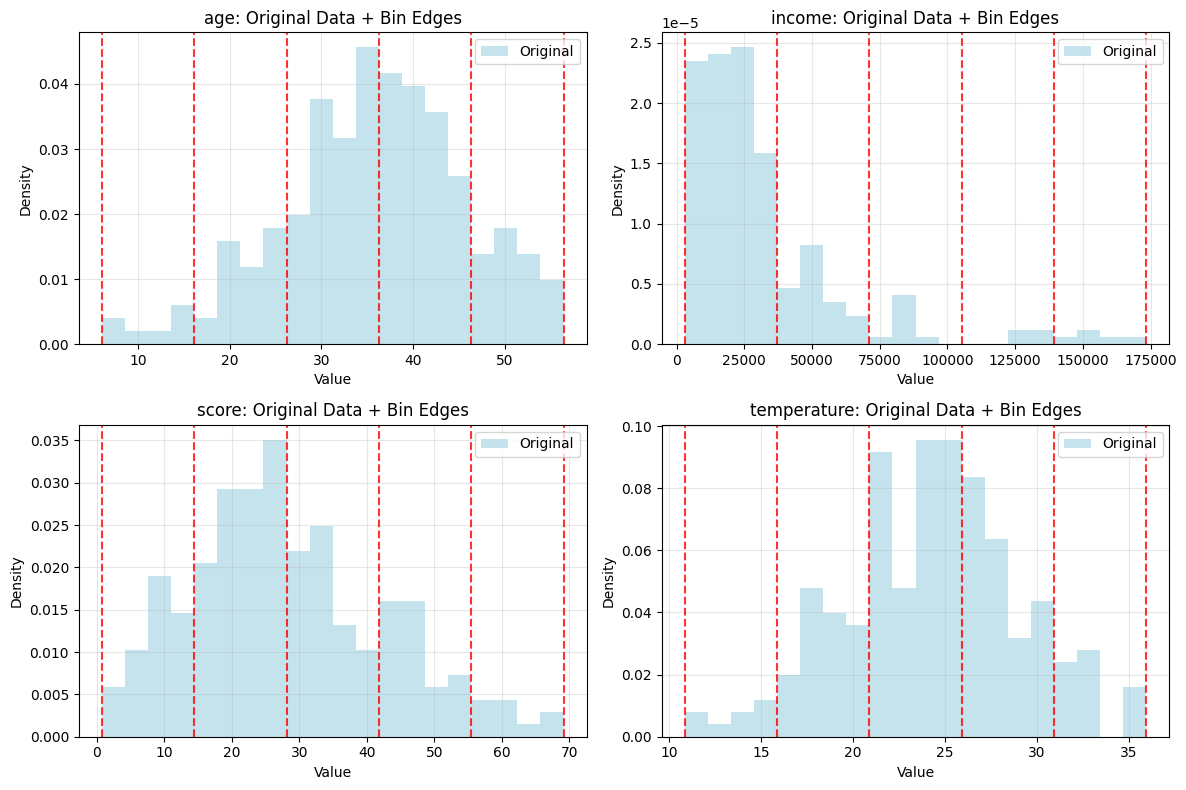

📊 Bin distribution for each feature:

age:
  Bin 0: 7 samples (3.5%)
  Bin 1: 25 samples (12.5%)
  Bin 2: 68 samples (34.0%)
  Bin 3: 72 samples (36.0%)
  Bin 4: 28 samples (14.0%)

income:
  Bin 0: 150 samples (75.0%)
  Bin 1: 32 samples (16.0%)
  Bin 2: 9 samples (4.5%)
  Bin 3: 4 samples (2.0%)
  Bin 4: 5 samples (2.5%)

score:
  Bin 0: 34 samples (17.0%)
  Bin 1: 78 samples (39.0%)
  Bin 2: 48 samples (24.0%)
  Bin 3: 31 samples (15.5%)
  Bin 4: 9 samples (4.5%)

temperature:
  Bin 0: 8 samples (4.0%)
  Bin 1: 36 samples (18.0%)
  Bin 2: 83 samples (41.5%)
  Bin 3: 56 samples (28.0%)
  Bin 4: 17 samples (8.5%)


In [4]:
# Visualize the binning results
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(df_data.columns):
    ax = axes[i]

    # Plot original data distribution
    ax.hist(df_data[col], bins=20, alpha=0.7, color='lightblue', label='Original', density=True)

    # Plot bin edges as vertical lines
    for edge in basic_binner.bin_edges_[col]:
        ax.axvline(edge, color='red', linestyle='--', alpha=0.8)

    ax.set_title(f'{col}: Original Data + Bin Edges')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show bin distribution
print("📊 Bin distribution for each feature:")
for col in df_data.columns:
    bin_counts = df_binned[col].value_counts().sort_index()
    print(f"\n{col}:")
    for bin_id, count in bin_counts.items():
        print(f"  Bin {bin_id}: {count} samples ({count/len(df_data)*100:.1f}%)")

In [5]:
print("🔄 Inverse Transform Demonstration")

# Demonstrate inverse_transform functionality
print("\n📍 Original → Binned → Inverse Transform")

# Take a subset of original data for clear demonstration
sample_data = df_data.iloc[:5].copy()
print("Original sample data:")
print(sample_data.round(2))

# Transform to bins
binned_sample = basic_binner.transform(sample_data)
print("\nBinned data:")
print(binned_sample)

# Inverse transform back to continuous values
print("\n🔁 Applying inverse_transform...")
inverse_result = basic_binner.inverse_transform(binned_sample)
print("Inverse transformed data:")
print(inverse_result.round(2))

# Compare with original data
print("\n📊 Comparison Analysis:")
print("Column-wise comparison (Original vs Inverse):")
for col in sample_data.columns:
    original_values = sample_data[col].values
    inverse_values = inverse_result[col].values

    print(f"\n{col}:")
    print(f"  Original range: [{original_values.min():.2f}, {original_values.max():.2f}]")
    print(f"  Inverse range:  [{inverse_values.min():.2f}, {inverse_values.max():.2f}]")

    # Check if inverse values are bin centers
    bin_edges = basic_binner.bin_edges_[col]
    bin_centers = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(len(bin_edges)-1)]
    print(f"  Bin centers:    {[f'{center:.2f}' for center in bin_centers]}")
    print(f"  Unique inverse: {sorted({f'{val:.2f}' for val in inverse_values})}")

# Demonstrate the round-trip property
print("\n🔄 Round-trip Property Test:")
print("The inverse_transform returns bin center values, not exact original values.")
print("This is expected behavior for equal-width binning.")

# Show bin center calculation
print("\n🎯 Understanding Bin Centers:")
for col in df_data.columns[:2]:  # Show for first 2 columns
    edges = basic_binner.bin_edges_[col]
    print(f"\n{col}:")
    for i in range(len(edges)-1):
        center = (edges[i] + edges[i+1]) / 2
        print(f"  Bin {i}: [{edges[i]:.2f}, {edges[i+1]:.2f}] → center: {center:.2f}")

# Practical use case example
print("\n💡 Practical Use Case:")
print("1. You have continuous data that you need to bin for a model")
print("2. After model predictions, you want approximate continuous values")
print("3. inverse_transform gives you the bin center as the representative value")

# Demonstrate with extreme example
extreme_data = pd.DataFrame({'feature': [10, 50, 90]})
extreme_binner = EqualWidthBinning(n_bins=3, preserve_dataframe=True)
extreme_binned = extreme_binner.fit_transform(extreme_data)
extreme_inverse = extreme_binner.inverse_transform(extreme_binned)

print("\nExtreme example:")
print(f"Original:  {extreme_data['feature'].values}")
print(f"Binned:    {extreme_binned['feature'].values}")
print(f"Inverse:   {extreme_inverse['feature'].values}")
print(f"Bin edges: {np.round(extreme_binner.bin_edges_['feature'], 2)}")
print(f"Expected centers: {[np.round((extreme_binner.bin_edges_['feature'][i] + extreme_binner.bin_edges_['feature'][i+1])/2, 2) for i in range(3)]}")

🔄 Inverse Transform Demonstration

📍 Original → Binned → Inverse Transform
Original sample data:
     age    income  score  temperature
0  31.92  18910.15  19.69        22.46
1  37.19  26211.31  41.51        15.83
2  37.49  44181.18  18.92        24.86
3  50.77  32746.31  22.76        26.68
4  34.05  24843.09  52.76        20.26

Binned data:
   age  income  score  temperature
0    2       0      1            2
1    3       0      2            0
2    3       1      1            2
3    4       0      1            3
4    2       0      3            1

🔁 Applying inverse_transform...
Inverse transformed data:
     age    income  score  temperature
0  31.23  20031.27  21.24        23.39
1  41.31  20031.27  34.92        13.35
2  41.31  54129.05  21.24        23.39
3  51.38  20031.27  21.24        28.41
4  31.23  20031.27  48.60        18.37

📊 Comparison Analysis:
Column-wise comparison (Original vs Inverse):

age:
  Original range: [31.92, 50.77]
  Inverse range:  [31.23, 51.38]
  Bin cent

## 4. Different Input/Output Formats

`EqualWidthBinning` is designed to handle various data formats seamlessly. Let's explore its flexibility:

In [6]:
print("🔄 Testing different input/output formats...")

# 1. NumPy Array Input → NumPy Array Output (default)
print("\n1️⃣ NumPy Array → NumPy Array")
numpy_binner = EqualWidthBinning(n_bins=4)
numpy_result = numpy_binner.fit_transform(numpy_data)

print(f"Input type: {type(numpy_data)}, shape: {numpy_data.shape}")
print(f"Output type: {type(numpy_result)}, shape: {numpy_result.shape}")
print(f"Sample transformation: {numpy_data[0]} → {numpy_result[0]}")

# 2. DataFrame Input → DataFrame Output (with preserve_dataframe=True)
print("\n2️⃣ DataFrame → DataFrame (preserve_dataframe=True)")
df_binner = EqualWidthBinning(n_bins=4, preserve_dataframe=True)
df_result = df_binner.fit_transform(df_data)

print(f"Input type: {type(df_data)}, shape: {df_data.shape}")
print(f"Output type: {type(df_result)}, shape: {df_result.shape}")
print(f"Columns preserved: {list(df_result.columns)}")
print("Sample row transformation:")
print(f"  Original: {dict(df_data.iloc[0])}")
print(f"  Binned:   {dict(df_result.iloc[0])}")

# 3. DataFrame Input → NumPy Array Output (preserve_dataframe=False)
print("\n3️⃣ DataFrame → NumPy Array (preserve_dataframe=False)")
df_to_numpy_binner = EqualWidthBinning(n_bins=4, preserve_dataframe=False)
df_to_numpy_result = df_to_numpy_binner.fit_transform(df_data)

print(f"Input type: {type(df_data)}, shape: {df_data.shape}")
print(f"Output type: {type(df_to_numpy_result)}, shape: {df_to_numpy_result.shape}")

# 4. Single feature array (2D)
print("\n5️⃣ Single Feature Array (2D)")
single_feature = numpy_data[:, 0:1]  # Keep 2D structure
single_binner = EqualWidthBinning(n_bins=6)
single_result = single_binner.fit_transform(single_feature)

print(f"Input type: {type(single_feature)}, shape: {single_feature.shape}")
print(f"Output type: {type(single_result)}, shape: {single_result.shape}")
print(f"Bin edges: {np.round(single_binner.bin_edges_[0], 2)}")

🔄 Testing different input/output formats...

1️⃣ NumPy Array → NumPy Array
Input type: <class 'numpy.ndarray'>, shape: (200, 3)
Output type: <class 'numpy.ndarray'>, shape: (200, 3)
Sample transformation: [57.4507123   0.52078604 59.50779307] → [2 0 2]

2️⃣ DataFrame → DataFrame (preserve_dataframe=True)
Input type: <class 'pandas.core.frame.DataFrame'>, shape: (200, 4)
Output type: <class 'pandas.core.frame.DataFrame'>, shape: (200, 4)
Columns preserved: ['age', 'income', 'score', 'temperature']
Sample row transformation:
  Original: {'age': np.float64(31.922217650469992), 'income': np.float64(18910.149724995998), 'score': np.float64(19.69332316073128), 'temperature': np.float64(22.455181871462507)}
  Binned:   {'age': np.int64(2), 'income': np.int64(0), 'score': np.int64(1), 'temperature': np.int64(1)}

3️⃣ DataFrame → NumPy Array (preserve_dataframe=False)
Input type: <class 'pandas.core.frame.DataFrame'>, shape: (200, 4)
Output type: <class 'numpy.ndarray'>, shape: (200, 4)

5️⃣ Si

## 5. Clipping Behavior

EqualWidthBinning provides configurable clipping behavior for handling values outside the bin ranges. Let's explore how this works:

In [7]:
print("🔒 Clipping Behavior Demonstration")

# Create data with intentional outliers
training_data = np.array([[10, 20], [15, 25], [20, 30], [25, 35], [30, 40]])
test_data_with_outliers = np.array([[5, 15], [35, 45], [0, 10], [40, 50]])  # Values outside training range

print(f"Training data range: {training_data.min(axis=0)} to {training_data.max(axis=0)}")
print(f"Test data range: {test_data_with_outliers.min(axis=0)} to {test_data_with_outliers.max(axis=0)}")

# Test with clipping enabled (default)
print("\n1️⃣ With Clipping Enabled (clip=True)")
binner_with_clipping = EqualWidthBinning(n_bins=3, clip=True)
binner_with_clipping.fit(training_data)

print(f"Bin edges: {binner_with_clipping.bin_edges_}")

# Transform test data with outliers
clipped_result = binner_with_clipping.transform(test_data_with_outliers)
print("Test data with outliers:")
print(f"Original: {test_data_with_outliers}")
print(f"Clipped:  {clipped_result}")

# Test with clipping disabled
print("\n2️⃣ With Clipping Disabled (clip=False)")
binner_no_clipping = EqualWidthBinning(n_bins=3, clip=False)
binner_no_clipping.fit(training_data)

# Transform test data with outliers
no_clip_result = binner_no_clipping.transform(test_data_with_outliers)
print("Test data with outliers:")
print(f"Original:   {test_data_with_outliers}")
print(f"No clip:    {no_clip_result}")

# Explain special values
print("\n📝 Special Values in Non-Clipped Results:")
print("  • -2: BELOW_RANGE (value below minimum bin edge)")
print("  • -1: ABOVE_RANGE (value above maximum bin edge)")
print("  • -3: MISSING_VALUE (NaN values)")

# Demonstrate with missing values
print("\n3️⃣ Handling Missing Values")
data_with_nan = np.array([[10, 20], [np.nan, 25], [20, np.nan], [25, 35]])

nan_result_clip = binner_with_clipping.transform(data_with_nan)
nan_result_no_clip = binner_no_clipping.transform(data_with_nan)

print("Data with NaN:")
print(f"Original:     {data_with_nan}")
print(f"Clipped:      {nan_result_clip}")
print(f"No clip:      {nan_result_no_clip}")

# Visual comparison
print("\n4️⃣ Practical Implications")
print("Clipping enabled:")
print("  ✅ Always produces valid bin indices (0 to n_bins-1)")
print("  ✅ Suitable for most ML pipelines")
print("  ⚠️  May lose information about extreme outliers")

print("\nClipping disabled:")
print("  ✅ Preserves information about out-of-range values")
print("  ✅ Useful for outlier detection and data quality analysis")
print("  ⚠️  Requires special handling for special values (-2, -1, -3)")

🔒 Clipping Behavior Demonstration
Training data range: [10 20] to [30 40]
Test data range: [ 0 10] to [40 50]

1️⃣ With Clipping Enabled (clip=True)
Bin edges: {0: [10.0, 16.666666666666668, 23.333333333333336, 30.0], 1: [20.0, 26.666666666666668, 33.333333333333336, 40.0]}
Test data with outliers:
Original: [[ 5 15]
 [35 45]
 [ 0 10]
 [40 50]]
Clipped:  [[0 0]
 [2 2]
 [0 0]
 [2 2]]

2️⃣ With Clipping Disabled (clip=False)
Test data with outliers:
Original:   [[ 5 15]
 [35 45]
 [ 0 10]
 [40 50]]
No clip:    [[-3 -3]
 [-2 -2]
 [-3 -3]
 [-2 -2]]

📝 Special Values in Non-Clipped Results:
  • -2: BELOW_RANGE (value below minimum bin edge)
  • -1: ABOVE_RANGE (value above maximum bin edge)
  • -3: MISSING_VALUE (NaN values)

3️⃣ Handling Missing Values
Data with NaN:
Original:     [[10. 20.]
 [nan 25.]
 [20. nan]
 [25. 35.]]
Clipped:      [[ 0  0]
 [-1  0]
 [ 1 -1]
 [ 2  2]]
No clip:      [[ 0  0]
 [-1  0]
 [ 1 -1]
 [ 2  2]]

4️⃣ Practical Implications
Clipping enabled:
  ✅ Always produces 

## 6. Joint Fitting

EqualWidthBinning can fit bins either jointly across all features or independently for each feature. This setting affects how bin edges are determined when working with multiple columns.

In [8]:
print("🔗 Joint Fitting Demonstration")

# Create sample data with different scales
data_different_scales = np.array([
    [10, 1000],
    [20, 2000],
    [30, 3000],
    [40, 4000],
    [50, 5000]
])

print("Sample data with different scales:")
print(f"Feature 1 range: {data_different_scales[:, 0].min()} to {data_different_scales[:, 0].max()}")
print(f"Feature 2 range: {data_different_scales[:, 1].min()} to {data_different_scales[:, 1].max()}")

# Test with joint fitting enabled (default)
print("\n1️⃣ With Joint Fitting (fit_jointly=True)")
binner_joint = EqualWidthBinning(n_bins=3, fit_jointly=True)
binner_joint.fit(data_different_scales)

print(f"Bin edges: {binner_joint.bin_edges_}")
print("Note: All features share the same bin edges based on global min/max")

joint_result = binner_joint.transform(data_different_scales)
print("Transformed data:")
print(joint_result)

# Test with independent fitting
print("\n2️⃣ With Independent Fitting (fit_jointly=False)")
binner_independent = EqualWidthBinning(n_bins=3, fit_jointly=False)
binner_independent.fit(data_different_scales)

print(f"Bin edges: {binner_independent.bin_edges_}")
print("Note: Each feature has its own bin edges based on per-column min/max")

independent_result = binner_independent.transform(data_different_scales)
print("Transformed data:")
print(independent_result)

# Demonstrate the difference more clearly
print("\n3️⃣ Impact Analysis")

# Create data where joint vs independent makes a big difference
extreme_data = np.array([
    [1, 1000],
    [2, 2000],
    [3, 3000],
    [4, 4000],
    [5, 5000]
])

print("\nExtreme scale difference data:")
print(extreme_data)

# Joint fitting
binner_joint_extreme = EqualWidthBinning(n_bins=2, fit_jointly=True)
binner_joint_extreme.fit(extreme_data)
joint_extreme_result = binner_joint_extreme.transform(extreme_data)

print("\nJoint fitting result:")
print(f"Bin edges: {binner_joint_extreme.bin_edges_}")
print(f"Transformed: {joint_extreme_result}")

# Independent fitting
binner_independent_extreme = EqualWidthBinning(n_bins=2, fit_jointly=False)
binner_independent_extreme.fit(extreme_data)
independent_extreme_result = binner_independent_extreme.transform(extreme_data)

print("\nIndependent fitting result:")
print(f"Bin edges: {binner_independent_extreme.bin_edges_}")
print(f"Transformed: {independent_extreme_result}")

print("\n4️⃣ Use Case Recommendations")
print("Joint Fitting (fit_jointly=True):")
print("  ✅ When you want consistent binning across all features")
print("  ✅ When features represent similar quantities with comparable scales")
print("  ✅ For dimensionality reduction or feature standardization")
print("  ⚠️  May be less effective with features of very different scales")

print("\nIndependent Fitting (fit_jointly=False):")
print("  ✅ When features have different scales or units")
print("  ✅ When you want optimal binning for each feature individually")
print("  ✅ Most common use case for mixed-type data")
print("  ⚠️  Features may end up with different bin edge patterns")

# Practical example with mixed data types
print("\n5️⃣ Mixed Data Example")
mixed_data = pd.DataFrame({
    'age': [25, 30, 35, 40, 45, 50],
    'income': [30000, 45000, 60000, 75000, 90000, 120000],
    'score': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
})

print("Mixed data types:")
print(mixed_data)

binner_mixed_joint = EqualWidthBinning(n_bins=2, fit_jointly=True, preserve_dataframe=True)
binner_mixed_independent = EqualWidthBinning(n_bins=2, fit_jointly=False, preserve_dataframe=True)

result_joint = binner_mixed_joint.fit_transform(mixed_data)
result_independent = binner_mixed_independent.fit_transform(mixed_data)

print("\nJoint fitting on mixed data:")
print(result_joint)

print("\nIndependent fitting on mixed data:")
print(result_independent)

print(f"\nJoint bin edges: {binner_mixed_joint.bin_edges_}")
print(f"Independent bin edges: {binner_mixed_independent.bin_edges_}")

🔗 Joint Fitting Demonstration
Sample data with different scales:
Feature 1 range: 10 to 50
Feature 2 range: 1000 to 5000

1️⃣ With Joint Fitting (fit_jointly=True)
Bin edges: {0: [10.0, 1673.3333333333333, 3336.6666666666665, 5000.0], 1: [10.0, 1673.3333333333333, 3336.6666666666665, 5000.0]}
Note: All features share the same bin edges based on global min/max
Transformed data:
[[0 0]
 [0 1]
 [0 1]
 [0 2]
 [0 2]]

2️⃣ With Independent Fitting (fit_jointly=False)
Bin edges: {0: [10.0, 23.333333333333336, 36.66666666666667, 50.0], 1: [1000.0, 2333.333333333333, 3666.6666666666665, 5000.0]}
Note: Each feature has its own bin edges based on per-column min/max
Transformed data:
[[0 0]
 [0 0]
 [1 1]
 [2 2]
 [2 2]]

3️⃣ Impact Analysis

Extreme scale difference data:
[[   1 1000]
 [   2 2000]
 [   3 3000]
 [   4 4000]
 [   5 5000]]

Joint fitting result:
Bin edges: {0: [1.0, 2500.5, 5000.0], 1: [1.0, 2500.5, 5000.0]}
Transformed: [[0 0]
 [0 0]
 [0 1]
 [0 1]
 [0 1]]

Independent fitting result:

## 7. Sklearn Pipeline Integration

EqualWidthBinning works seamlessly with scikit-learn pipelines, allowing for complex data preprocessing workflows.

In [9]:

print("🔗 Sklearn Pipeline Integration Demo")

# Create a synthetic target variable for classification
np.random.seed(42)
y_binary = (numpy_data[:, 0] + numpy_data[:, 1] > numpy_data.mean()) * 1

# Split data for demonstration
X_train, X_test, y_train, y_test = train_test_split(
    numpy_data, y_binary, test_size=0.3, random_state=42
)

# Create pipeline with EqualWidthBinning
print("\n1️⃣ Pipeline: Binning → Scaling → Random Forest")
pipeline_with_binning = Pipeline([
    ('binning', EqualWidthBinning(n_bins=5)),
    ('classifier', RandomForestClassifier(n_estimators=10, random_state=42))
])

# Fit and evaluate
pipeline_with_binning.fit(X_train, y_train)
y_pred_binned = pipeline_with_binning.predict(X_test)
accuracy_binned = accuracy_score(y_test, y_pred_binned)

print(f"Accuracy with binning: {accuracy_binned:.3f}")

# Compare without binning
print("\n2️⃣ Baseline Pipeline: Scaling → Random Forest (no binning)")
pipeline_without_binning = Pipeline([
    ('classifier', RandomForestClassifier(n_estimators=10, random_state=42))
])

pipeline_without_binning.fit(X_train, y_train)
y_pred_no_binning = pipeline_without_binning.predict(X_test)
accuracy_no_binning = accuracy_score(y_test, y_pred_no_binning)

print(f"Accuracy without binning: {accuracy_no_binning:.3f}")

# Pipeline inspection
print("\n3️⃣ Pipeline Inspection")
print("Pipeline steps:")
for step_name, step_obj in pipeline_with_binning.named_steps.items():
    print(f"  • {step_name}: {type(step_obj).__name__}")

# Access fitted binner parameters
fitted_binner = pipeline_with_binning.named_steps['binning']
print("\nFitted binning parameters:")
print(f"  • Number of bins: {fitted_binner.n_bins}")
print(f"  • Bin edges shape: {len(fitted_binner.bin_edges_)} features")
print(f"  • First feature bin edges: {np.round(fitted_binner.bin_edges_[0], 2)}")

🔗 Sklearn Pipeline Integration Demo

1️⃣ Pipeline: Binning → Scaling → Random Forest
Accuracy with binning: 0.933

2️⃣ Baseline Pipeline: Scaling → Random Forest (no binning)
Accuracy without binning: 1.000

3️⃣ Pipeline Inspection
Pipeline steps:
  • binning: EqualWidthBinning
  • classifier: RandomForestClassifier

Fitted binning parameters:
  • Number of bins: 5
  • Bin edges shape: 3 features
  • First feature bin edges: [15.47 28.6  41.74 54.87 68.   81.13]


## 8. Serialization and Parameter Reconstruction

One powerful feature of EqualWidthBinning is the ability to extract fitted parameters and reconstruct the binner, enabling model persistence and deployment scenarios.

In [10]:
print("💾 Serialization and Reconstruction Demo")

# Step 1: Fit a binner with specific configuration
print("\n1️⃣ Training Original Binner")
original_binner = EqualWidthBinning(n_bins=7, preserve_dataframe=True)
original_binner.fit(df_data)

# Apply transformation with original binner
original_result = original_binner.transform(df_data.iloc[:5])
print("Original binner fitted and applied to 5 samples")
print(f"Input shape: {df_data.iloc[:5].shape}, Output shape: {original_result.shape}")

# Step 2: Extract all parameters (fitted state)
print("\n2️⃣ Parameter Extraction with get_params()")
fitted_params = original_binner.get_params()
print("Extracted parameters:")
for param_name, param_value in fitted_params.items():
    if hasattr(param_value, 'shape'):
        print(f"  • {param_name}: array with shape {param_value.shape}")
    elif isinstance(param_value, list | tuple) and len(param_value) > 3:
        print(f"  • {param_name}: {type(param_value).__name__} with {len(param_value)} elements")
    else:
        print(f"  • {param_name}: {param_value}")

# Step 3: Create new binner instance and reconstruct
print("\n3️⃣ Reconstructing Binner from Parameters")
reconstructed_binner = EqualWidthBinning()

# Set parameters to reconstruct the exact same state
reconstructed_binner.set_params(**fitted_params)

print("✅ Reconstruction complete!")
print(f"Reconstructed binner has same configuration: {reconstructed_binner.n_bins} bins")

# Step 4: Validation - both binners should produce identical results
print("\n4️⃣ Validation: Comparing Outputs")
reconstructed_result = reconstructed_binner.transform(df_data.iloc[:5])

# Check if results are identical
results_identical = np.allclose(original_result.values, reconstructed_result.values)
print(f"Results identical: {results_identical} ✅" if results_identical else f"Results identical: {results_identical} ❌")

if results_identical:
    print("Perfect reconstruction achieved! 🎯")
else:
    print("Differences found - checking details...")
    diff = np.abs(original_result.values - reconstructed_result.values)
    print(f"Maximum difference: {np.max(diff)}")

# Step 5: Practical Application - Transform New Data
print("\n5️⃣ Transform New Data with Reconstructed Binner")
# Create some new test data
new_data = pd.DataFrame({
    'age': [25, 45, 65],
    'income': [50000, 75000, 120000],
    'score': [85, 92, 78],
    'temperature': [22, 28, 19]
})

print("New data to transform:")
print(new_data)

# Transform with both original and reconstructed binners
new_result_original = original_binner.transform(new_data)
new_result_reconstructed = reconstructed_binner.transform(new_data)

print("\nTransformation results:")
print("Original binner result:")
print(new_result_original)
print("\nReconstructed binner result:")
print(new_result_reconstructed)

# Verify they're identical
new_identical = np.allclose(new_result_original.values, new_result_reconstructed.values)
print(f"\nNew data transformation identical: {new_identical} ✅" if new_identical else f"New data transformation identical: {new_identical} ❌")

💾 Serialization and Reconstruction Demo

1️⃣ Training Original Binner
Original binner fitted and applied to 5 samples
Input shape: (5, 4), Output shape: (5, 4)

2️⃣ Parameter Extraction with get_params()
Extracted parameters:
  • bin_edges: {'age': [6.037446218063106, 13.235340127785324, 20.433234037507546, 27.631127947229764, 34.82902185695198, 42.02691576667421, 49.22480967639642, 56.42270358611864], 'income': [2982.3755551862555, 27337.936767692296, 51693.497980198335, 76049.05919270437, 100404.62040521041, 124760.18161771646, 149115.74283022247, 173471.30404272853], 'score': [0.7247912732123117, 10.495668786166876, 20.26654629912144, 30.037423812076007, 39.80830132503057, 49.57917883798513, 59.3500563509397, 69.12093386389427], 'temperature': [10.837402146118958, 14.42323746420912, 18.00907278229928, 21.594908100389446, 25.180743418479608, 28.76657873656977, 32.35241405465993, 35.93824937275009]}
  • bin_range: None
  • bin_representatives: {'age': [9.636393172924215, 16.8342870826

## 9. Summary and Advanced Features

This notebook demonstrated the key capabilities of `EqualWidthBinning`:

### ✅ Core Features Covered:
- **Basic binning** with customizable number of bins
- **Flexible input/output** supporting NumPy arrays and pandas DataFrames
- **Sklearn pipeline integration** for complex preprocessing workflows
- **Parameter serialization** enabling model persistence and deployment
- **Data format preservation** with `preserve_dataframe` option

### 🚀 Key Advantages:
1. **Sklearn Compatible**: Full scikit-learn API compliance with `fit()`, `transform()`, `fit_transform()`
2. **Production Ready**: Robust serialization capabilities for model deployment
3. **Flexible Data Handling**: Seamless work with different data formats
4. **Pipeline Integration**: Easy incorporation into complex ML workflows
5. **Parameter Transparency**: Complete access to fitted parameters via `get_params()`

### 📈 Use Cases:
- **Feature Engineering**: Converting continuous variables to categorical for tree-based models
- **Data Preprocessing**: Standardizing value ranges across different features
- **Model Deployment**: Saving fitted binning parameters for consistent preprocessing
- **Pipeline Development**: Integration with other sklearn transformers and estimators

### 🔗 Next Steps:
- Explore other binning methods: `EqualFrequencyBinning`, `KMeansBinning`, `SupervisedBinning`
- Combine multiple binning strategies in ensemble preprocessing pipelines
- Investigate domain-specific binning strategies for your data

---
**💡 Tip**: For more advanced use cases, check out the other binning methods in the `binlearn` library, including supervised binning methods that use target variable information for optimal bin placement!